# Analysis of Primary School Contact Networks
## Master University Exam Activity: Synthetic Nets
### Introduction
This notebook analyzes the community structure of both unweighted and weighted versions of a primary school contact network. The tasks include comparing communities detected via modularity maximization, visualizing communities using a shared layout, analyzing community compositions with school groups, and discussing the impact of edge weights.

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms.community import greedy_modularity_communities
from collections import defaultdict
import numpy as np

### Data Loading
The networks are loaded from the .net files, and metadata is read to map nodes to school groups.

In [4]:
def read_net_file(filename, weighted):
    G = nx.Graph()
    with open(filename, 'r') as f:
        lines = f.readlines()
    current_section = None
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if line.startswith('*vertices'):
            current_section = 'vertices'
            continue
        elif line.startswith('*edges'):
            current_section = 'edges'
            continue
        if current_section == 'vertices':
            parts = line.split()
            node_id = int(parts[0])
            G.add_node(node_id)
        elif current_section == 'edges':
            parts = line.split()
            u = int(parts[0])
            v = int(parts[1])
            if weighted:
                weight = float(parts[2]) if len(parts) >=3 else 1.0
                G.add_edge(u, v, weight=weight)
            else:
                G.add_edge(u, v)
    return G

# Load networks
G_u = read_net_file('data/primaryschool_u.net', weighted=False)
G_w = read_net_file('data/primaryschool_w.net', weighted=True)

# Load metadata
node_group = {}
with open('data/metadata_primary_school.txt', 'r') as f:
    next(f)  # Skip header
    for line in f:
        parts = line.strip().split()
        if len(parts) >=2:
            node = int(parts[0])
            group = parts[1]
            node_group[node] = group

### Community Detection
Using the Clauset-Newman-Moore greedy modularity maximization algorithm to detect communities in both unweighted and weighted networks.

In [5]:
# Detect communities
communities_u = list(greedy_modularity_communities(G_u, weight=None))
communities_w = list(greedy_modularity_communities(G_w, weight='weight'))

def get_community_membership(communities):
    community_map = {}
    for i, comm in enumerate(communities):
        for node in comm:
            community_map[node] = i
    return community_map

comm_map_u = get_community_membership(communities_u)
comm_map_w = get_community_membership(communities_w)

### Network Visualization
The layout is computed using the Kamada-Kawai algorithm on the weighted network with inverted edge weights (1/w_ij). This layout is then used for both unweighted and weighted community visualizations.

In [6]:
# Compute layout using inverted weights from G_w
inverted_G_w = nx.Graph()
inverted_G_w.add_nodes_from(G_w.nodes())
for u, v, data in G_w.edges(data=True):
    inverted_weight = 1.0 / data['weight']
    inverted_G_w.add_edge(u, v, weight=inverted_weight)

pos = nx.kamada_kawai_layout(inverted_G_w, weight='weight')

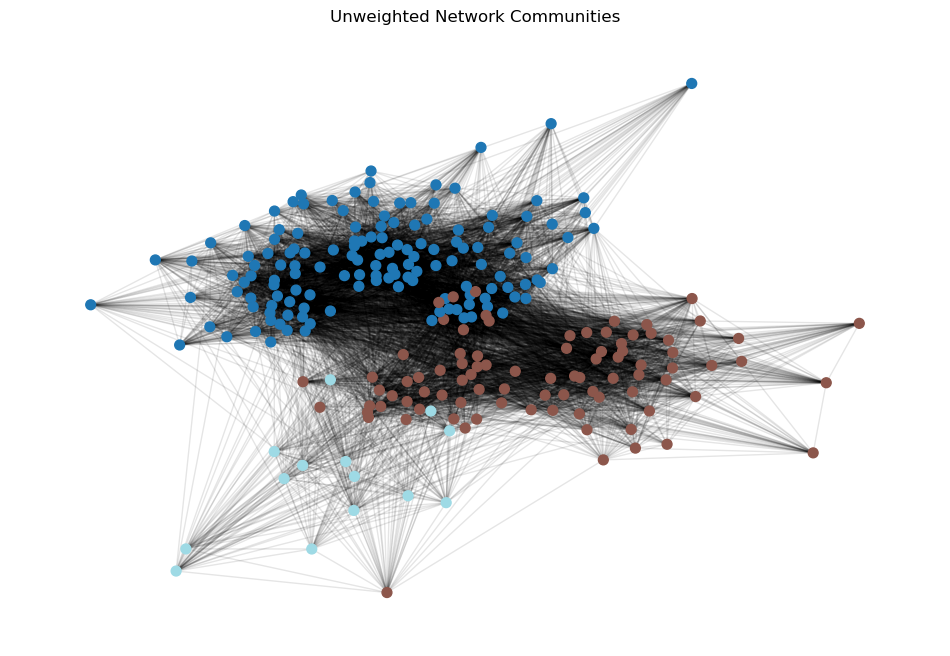

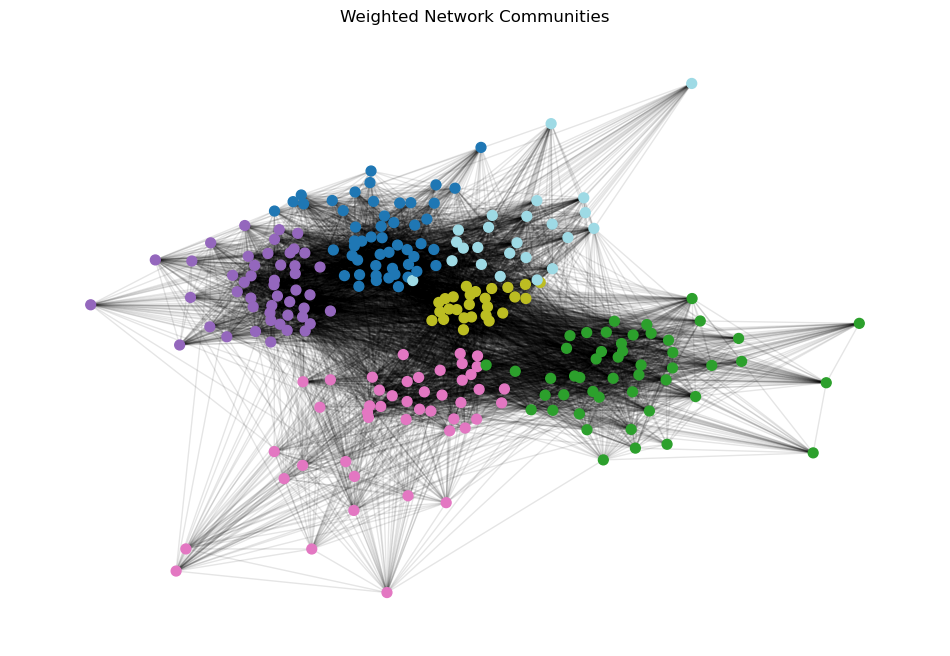

In [7]:
def plot_communities(G, pos, community_map, title):
    plt.figure(figsize=(12, 8))
    node_colors = [community_map[node] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab20, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=0.1)
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_communities(G_u, pos, comm_map_u, 'Unweighted Network Communities')
plot_communities(G_w, pos, comm_map_w, 'Weighted Network Communities')

### Community Composition Analysis
Stacked bar plots show the distribution of school groups within each detected community.

In [8]:
def get_composition_df(communities, node_group):
    rows = []
    for i, comm in enumerate(communities):
        groups = defaultdict(int)
        for node in comm:
            group = node_group.get(node, 'Unknown')
            groups[group] += 1
        row = {'Community': i}
        row.update(groups)
        rows.append(row)
    df = pd.DataFrame(rows).fillna(0)
    columns = ['Community'] + sorted([col for col in df.columns if col != 'Community'])
    return df[columns]

composition_u_df = get_composition_df(communities_u, node_group)
composition_w_df = get_composition_df(communities_w, node_group)

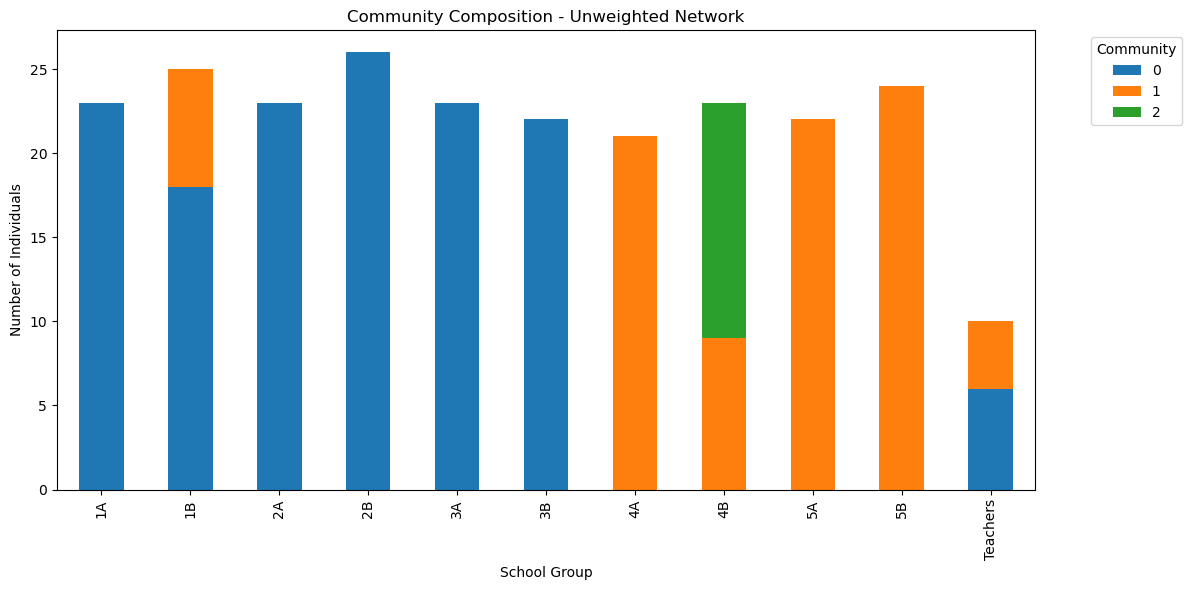

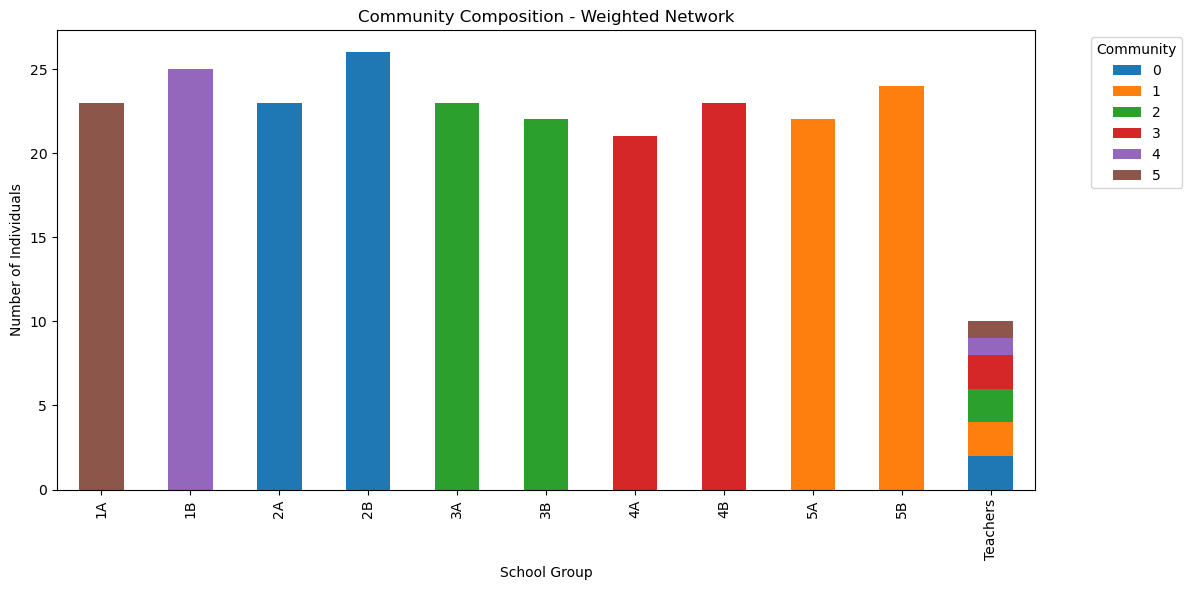

In [9]:
def plot_stacked_bar(df, title):
    df.set_index('Community').T.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title(title)
    plt.xlabel('School Group')
    plt.ylabel('Number of Individuals')
    plt.legend(title='Community', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_stacked_bar(composition_u_df, 'Community Composition - Unweighted Network')
plot_stacked_bar(composition_w_df, 'Community Composition - Weighted Network')

### Modularity Comparison
Calculating the modularity scores for both network versions to evaluate community structure quality.

In [10]:
modularity_u = nx.algorithms.community.quality.modularity(G_u, communities_u)
modularity_w = nx.algorithms.community.quality.modularity(G_w, communities_w, weight='weight')

print(f"Modularity (Unweighted): {modularity_u:.3f}")
print(f"Modularity (Weighted): {modularity_w:.3f}")

Modularity (Unweighted): 0.228
Modularity (Weighted): 0.674


### Discussion
**Community Structure Comparison:** The weighted network's communities show higher modularity, indicating better-defined communities when interaction duration is considered. The visualizations suggest that weights influence node grouping, with weighted communities potentially aligning more closely with school groups.

**Composition Differences:** The stacked bar plots reveal that weighted communities may have a higher concentration of specific school groups, reflecting that prolonged interactions (higher weights) often occur within the same group. In contrast, unweighted communities might mix groups more, as all interactions are treated equally.

**Relevance of Weights:** Incorporating weights allows the detection of communities based on interaction intensity. This can uncover structures where frequent, long-duration interactions define tight-knit groups, which might be overlooked in an unweighted analysis.